# Load librariers and dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [3]:
data = pd.read_pickle('../datasets/df_userID.pickle')
data.columns

Index(['Race', 'Date', 'RaceYear', 'RaceMonth', 'Category', 'Distance', 'Name',
       'Sex', 'Year', 'LivingPlace', 'Rank', 'Time', 'Pace', 'Place',
       'MinTemp', 'MaxTemp', 'Weather', 'RaceID', 'UserID'],
      dtype='object')

# Geographical scraping

In this section we want to find if there are statistically remarkable differences in terms of performance between runners from different Cantons. At first we have then to link each provenience city (saved as 'LivingPlace' in the dataset) to its own Canton. We will consider only the major Swiss cities in this analysis. The reader can refer to the following [web page](http://official-swiss-national-languages.all-about-switzerland.info/names-swiss-villages-towns-languages.html). This approximate procedure allows us to map roughly the 40% of the whole dataset, as we will verify. The geographical information is saved in an excel file named 'swisscities.xlsx'.

In [4]:
cities = pd.read_excel('swisscities.xlsx')
cities = cities[['Village / Town','Canton']]
cities['City']=cities['Village / Town']
del cities['Village / Town']

In [5]:
cities.head()

,Canton,City
0,TG,Aadorf
1,AG,Aarau
2,BE,Aarberg
3,AG,Aarburg
4,BE,Aarwangen


We extract all the living places in the dataset:

In [6]:
provenience = data.LivingPlace.unique()

Then we map each city to its own Canton, whenever it is possible; otherwise we set the corresponding Canton to 'nan' (null value).

In [7]:
general_mapping = {}
for city in provenience:
    if city in list(cities.City):
        general_mapping[city] = list(cities[cities.City==city].Canton)[0]
    else:
        general_mapping[city]='nan'

In [8]:
canton = []
for i in data.index:
    canton.append(general_mapping[data.loc[i].LivingPlace])
canton = pd.Series(data=canton,index=data.index)
data['LivingCanton']=canton

Finally we save a reduced version of the dataset, which will be slightly faster to manipulate:

In [9]:
geodata = data[data.LivingCanton!='nan']

As we anticipated, the length of the mapped subset of the dataset is around 40%:

In [10]:
len(geodata)/len(data)

0.39492780873864847

At first we would like to observe the evolution of the global runners number in time among all the competitions. To do this, we have to remove multiple occurrencies of runners in one single year. We assume as reasonable identifiers the name and the race year, neglecting possible homonyms (whose presence does not affect the overall distribution):

In [11]:
# unique identifier for runners in any year
geodata = geodata.drop_duplicates(['UserID','RaceYear'])

Then we count all the occurrencies for any Canton in time and save the results in a suitable dataframe:

In [12]:
cantons_per_year = {}
for year in range(np.min(geodata.RaceYear),np.max(geodata.RaceYear)+1):
    cantons_per_year[year]=geodata[geodata.RaceYear==year].LivingCanton.value_counts()

In [13]:
particip = []
years = range(np.min(geodata.RaceYear),np.max(geodata.RaceYear)+1)
for year in years:
    particip.append(cantons_per_year[year].sum())

In [14]:
cantons = geodata.LivingCanton.unique()
cantons = cantons[cantons!='nan']

In [15]:
time_evolution = pd.DataFrame()
for year in years:
    if 'BE/NE' in cantons_per_year[year].index:
        cantons_per_year[year]['BE']+=cantons_per_year[year]['BE/NE']
    time_evolution[year]=cantons_per_year[year]
cantons = cantons[cantons!='BE/NE']
time_evolution = time_evolution.set_index(cantons)
time_evolution

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
VS,1088,2799,2625,3257,3640,3629,4130,4426,4812,5003,4772,5497,5720,5304,5795,5665
BE,564,931,1404,1685,1903,2206,2408,2248,2191,2498,2472,2496,2611,2690,2981,2794
FR,168,659,737,973,563,639,778,1542,1450,1725,1994,2371,2653,2976,3142,3290
JU,146,1151,1532,3336,3691,3708,4589,4674,4896,5431,4091,4619,4963,4717,5141,3145
AG,139,687,789,1061,1149,1396,1371,1453,1200,1391,1302,1414,2199,2172,2303,1854
VD,139,383,508,803,1036,1619,1602,1383,1452,1504,1164,1218,1172,1146,1179,915
SO,137,927,1664,2189,1090,1762,3334,3358,2591,6118,6750,7132,7155,8527,9952,9687
LU,122,545,826,1092,1080,944,1384,1385,1488,2163,2211,2046,2104,2262,2216,1665
ZG,79,305,295,415,452,483,497,520,581,651,714,766,879,830,883,584
NE,75,137,192,192,184,175,227,241,298,380,333,328,284,206,260,213


To observe relative quantities, we need to consider also the overall population of each Canton. We have saved this information in another excel file, named 'canton_population.xslx'. After loading it, we use the *Bokeh* library to plot the results.

In [16]:
# population density per canton
canton_population = pd.read_excel('canton_population.xlsx')
canton_population = canton_population[['Canton','Population','Area']]
canton_population = canton_population.set_index('Canton')

# Time evolution: plots

With the following cells some *bokeh* plots are generated to visualize the time evolution of runners occurrencies both in general and by Canton:

In [17]:
from bokeh.plotting import figure, output_file, show
# output to static HTML file
output_file("overall.html")

p = figure(title = 'Number of participants vs time', plot_width=400, plot_height=400)
p.title.align = "center"
p.title.text_font_size = "16px"
p.xaxis[0].axis_label = 'year'
p.yaxis[0].axis_label = 'runners'
p.xaxis[0].axis_label_text_font_size = '14px'
p.yaxis[0].axis_label_text_font_size = '14px'

# add a circle renderer with a size, color, and alpha
p.line(years, particip, color="navy", line_width=1.5)
p.circle(years, particip, size=10, color="navy", alpha=0.5)

# show the results
show(p)

For the sake of clarity and cleaness of visualization, we report only the most significant Cantons:

In [18]:
colors = ['blue','red','green','orange','navy','chartreuse','darkmagenta','darkgoldenrod','darkslategrey','royalblue']

# output to static HTML file
output_file("plot.html")

years = range(2000,2016)
p = figure(title = 'Runners from some Cantons vs time', plot_width=600, plot_height=600)
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'year'
p.yaxis[0].axis_label = 'runners'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'
subindex = ['SO','BE','VD','VS','ZH','GE','TI','FR']
for k in range(len(subindex)):
    i = subindex[k]
    p.line(years, time_evolution.loc[i], legend = i, color=colors[k], line_width=2)
    p.circle(years, time_evolution.loc[i], size=7, color=colors[k])
p.legend.location = "top_left"
p.legend.label_text_font_size = '16px'
show(p)

In the following plot the population-normalized amount of runners is shown:

In [19]:
from bokeh.models import Label
output_file("plot.html")
p2 = figure(title = 'Ratio runners / Canton population vs time', plot_width=600, plot_height=600)
p2.title.align = "center"
p2.title.text_font_size = "18px"
p2.xaxis[0].axis_label = 'year'
p2.yaxis[0].axis_label = 'runners/population'
p2.xaxis[0].axis_label_text_font_size = '16px'
p2.yaxis[0].axis_label_text_font_size = '16px'
subindex = ['JU','SO','VD','VS','FR','BE','GE','ZH']
for k in range(len(subindex)):
    i = subindex[k]
    p2.line(years, time_evolution.loc[i]/canton_population.loc[i].Population, legend = i, color=colors[k], line_width=2)
    p2.circle(years, time_evolution.loc[i]/canton_population.loc[i].Population, size=7, color=colors[k])
p2.legend.location = "top_left"
p2.legend.label_text_font_size = '16px'
# show the results
show(p2)

# A qualitative visualization approach

In order to visualize Cantonal differences in terms of race time in a possibly efficient way, our idea is to apply a non-parametric test to mark statistical differences or similarities between Cantons (splitting the analysis by sex); after that, we will transform the p-values dataframe into a graph, whose nodes represent the cantons and whose edges stand for the verification of the null-hypothesis (that is, two nodes are connected when we cannot reject the null hypothesis, according to a certain threshold). This graph representation has the only purpose to evaluate the intensity of the interactions between Cantons; applying the Louvain modularity-based algorithm, we cluster the nodes into communties and finally display the result with a choropleth map of Switzerland. 

# Female Marathon

Here we focus on the female runners competing in the Marathons (42 km) and compare their times splitting them into groups per Canton. We work on a subset of the mapped dataframe.

In [20]:
df = geodata[(geodata.Sex=='F') &  (geodata.Distance>=41.0) & (geodata.Distance<=43.0)]
df.Time = df.Time.apply(lambda x: x.total_seconds()/60) # display time in minutes

C:\Users\Utente\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Cantonal differences:

In [21]:
from bokeh.charts import BoxPlot, output_file, show
from bokeh.plotting import figure, output_file, show

agg = df[['Time','LivingCanton']]
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = BoxPlot(agg, values='mean time [minutes]', label='Canton', outliers=False,legend=False,
            color='cornflowerblue',title='mean time boxplot for female marathon (42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

output_file("boxplot.html")

show(p)

Now we use the *scipy* library to perform suitable non-parametric tests for the population mean. In particular we use the Kolmogorov-Smirnov test (look [here](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) for basic references). In the following we define the samples per Cantonal division and compute the KS test p-values for all the pairs of Cantons, reporting the results in a dataframe. We proceed in this way because for multiple samples the KS test provides an answer for the existence of one arbitrary sample with a different mean with respect to the overall population, without identifying it. In some separate cells we take a look at the distribution of one arbitrary sample and compare it to a Gaussian, in order to verify if the normality hypothesis is valid (in which case we could use an ANOVA procedure).

In [22]:
import scipy.stats as stats
samples = []
for k in cantons:
    samples.append(df.Time[df.LivingCanton==k])

In [23]:
output_file("heteroschedasticity.html")

Nc = 1
sample = samples[Nc]
p = figure(title = 'Heteroschedasticity for time variable, Canton '+str(cantons[Nc]), plot_width=500, plot_height=500)
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'index'
p.yaxis[0].axis_label = 'residuals [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

# add a circle renderer with a size, color, and alpha
p.line(x=[0,len(sample)],y=[0,0],line_width=2,line_dash=[3,3],color='red')
p.circle(range(0,len(sample)), sample-np.mean(sample), size=5, color="navy", alpha=0.5)

# show the results
show(p)

In particular here we compute the p-value of the Shapiro-Wilk test for normality (see [here](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) for references).

In [24]:
Nc = 1
sample = samples[Nc]
stats.shapiro(sample)

(0.9851935505867004, 4.989008175471099e-06)

In [26]:
# normality hypothesis: Gaussian distribution, Shapiro-Wilk test
from bokeh.models import Label
import math

# add a circle renderer with a size, color, and alpha
from bokeh.charts import Histogram, output_file, show

df2 = pd.DataFrame({'time':sample})
p = Histogram(df2,values='time',color='navy',bins=30,
              title='Time PDF for Canton ' +str(cantons[Nc]),
              density=True,legend='top_right')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'time [minutes]'
p.yaxis[0].axis_label = 'density'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'
m = np.mean(sample)
sigma = np.std(sample)
def gaussian(y,m,sigma):
    return 1/math.sqrt(2*math.pi*sigma*sigma)*math.exp(-(y-m)*(y-m)/2/(sigma*sigma))
yy = np.arange(np.min(sample), np.max(sample), 0.1)
gg = []
for k in range(len(yy)):
    gg.append(gaussian(yy[k],m,sigma))
p.line(list(yy),gg,line_width=2,color='red',legend='Gaussian')

output_file("histogram_bins.html")

show(p)

Now we perform the crossed KS tests and report the p-values in a dataframe:

In [27]:
p_values = {}
for i in range(len(cantons)):
    for j in range(i,len(cantons)):
        p_values[(i,j)]=stats.ks_2samp(samples[i],samples[j])[1]

In [28]:
P_VALUES = pd.DataFrame()
for j in range(len(cantons)):
    col = []
    for i in range(0,j):
        p = p_values[(i,j)]
        col.append(p)
    col.append(1.0)
    for i in range(j+1,len(cantons)):
        p = p_values[(j,i)]
        col.append(p)
    col = pd.Series(data=col,index=cantons)
    P_VALUES[cantons[j]]=col

We report a subset of the dataframe for visualization purposes only:

In [29]:
P_VALUES[['VS','BE','VD','ZH']].loc[['VS','BE','VD','ZH']]

,VS,BE,VD,ZH
VS,1.000000e+00,7.579819e-02,8.378275e-03,2.260714e-09
BE,7.579819e-02,1.000000e+00,2.675667e-03,1.038911e-48
VD,8.378275e-03,2.675667e-03,1.000000e+00,4.398836e-07
ZH,2.260714e-09,1.038911e-48,4.398836e-07,1.000000e+00


Now we set a threshold alpha = 0.05 to mark all the significant p-values in the dataframe. This operation will allow us to observe which are the statistically significant differences among Cantons:

In [30]:
alpha = 0.05
for k in P_VALUES.columns:
    P_VALUES[k] = P_VALUES[k].apply(lambda y: (y<0.05))

In [31]:
P_VALUES[['VS','BE','VD','ZH','FR','TI']].loc[['VS','BE','VD','ZH','FR','TI']]

,VS,BE,VD,ZH,FR,TI
VS,False,False,True,True,False,True
BE,False,False,True,True,True,True
VD,True,True,False,True,False,False
ZH,True,True,True,False,True,False
FR,False,True,False,True,False,False
TI,True,True,False,False,False,False


To turn these statistical interactions into a visual object, we transform the dataframe into a graph object, whose nodes represent the cantons and whose edges stand for the 'False' entry (that is, the KS cannot provide evidence for the two Cantons to have different distributions). We use the *graph_tool* library to deal with such an instance:

In [32]:
positions = {}
positions['SH']=(0,0)
positions['ZH']=(0,-1)
positions['TG']=(1,-1)
positions['AG']=(-1,-1)
positions['BL']=(-2,-0.5)
positions['BS']=(-3,-0.5)
positions['SO']=(-2,-1.5)
positions['JU']=(-4,-1.5)
positions['SG']=(1,-3)
positions['AR']=(3.5,-2.5)
positions['AI']=(3.5,-3.5)
positions['GL']=(2.5,-3)
positions['SZ']=(0,-2.5)
positions['ZG']=(-1,-2.5)
positions['LU']=(-2,-2.5)
positions['NE']=(-4,-3)
positions['VD']=(-5,-4)
positions['GE']=(-6,-5)
positions['FR']=(-3,-4)
positions['BE']=(-2,-4)
positions['OW']=(-1,-4)
positions['NW']=(-0,-4)
positions['UR']=(1,-4)
positions['GR']=(3,-6)
positions['VS']=(-3,-5)
positions['TI']=(-1,-7)

In [33]:
import networkx as nx
G = nx.Graph()
cantons = list(cantons)
for i in range(len(cantons)):
    G.add_node(cantons[i],pos=positions[cantons[i]])
for i in range(len(cantons)):
    for j in range(i+1,len(cantons)):
        if P_VALUES[cantons[i]].loc[cantons[j]]==False:
            G.add_edge(cantons[i],cantons[j])

We visualize now the graph in a geometrical fashion:

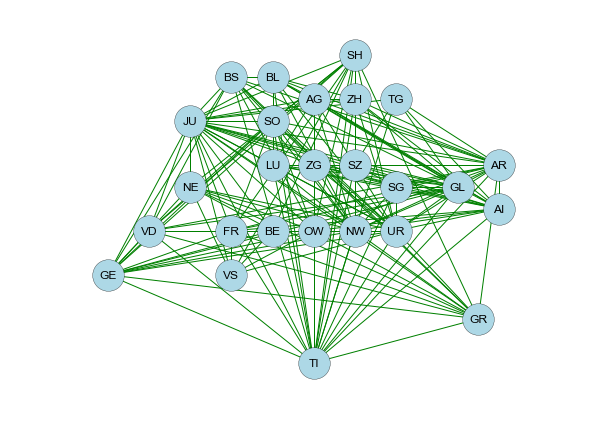

In [34]:
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos,node_color='lightblue',node_size=1000,with_labels=True,edge_color='green')

Since we want to bring out possible communities within the graph, we apply the modularity-based *Louvain algorithm* (see [here](https://en.wikipedia.org/wiki/Louvain_Modularity) for references), as we want to discover subsets of the graph which are "well" interconnected, rather than determine a hierarchical structure (for which the *Girvan-Newman* algorithm would be fine, [here](https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm) for references). We define the optimal graph partition within communities and compute its modularity measure.

Community 0
['AR', 'BL', 'TI', 'AG', 'SZ', 'JU', 'GL', 'SG', 'LU', 'AI', 'ZG', 'TG', 'ZH']
Community 1
['SO', 'BS', 'FR', 'NW', 'GR', 'VD', 'UR', 'OW', 'VS', 'NE', 'BE', 'SH', 'GE']


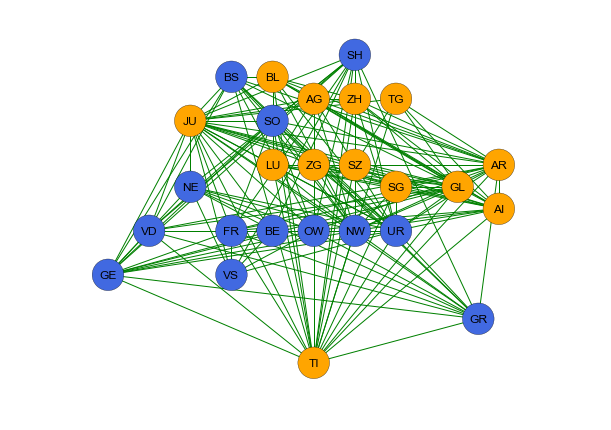

Modularity score: 0.19489929458329336


In [37]:
import community
partition = community.best_partition(G)

for i in set(partition.values()):
    print ("Community", i)
    members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]
    print (members)

values = [partition.get(node) for node in G.nodes()]
colors = {0 : 'orange', 1 : 'royalblue'}
cols = []
for i in range(len(values)):
    cols.append(colors[values[i]])
nx.draw(G, pos,cmap = plt.get_cmap('brg'), node_color = cols, node_size=1000, with_labels=True,edge_color='green')
plt.show()

print ("Modularity score:", community.modularity(partition, G))

The modularity measure is not very high (>0.3), which means that the two components are not much more connected than expected (in terms of the modularity approach). To observe if this clustering is meaningful or not, we recompute the bokeh boxplots with this peculiar partition and observe what it happens:

In [38]:
from bokeh.charts import BoxPlot, output_file, show
from bokeh.plotting import figure, output_file, show

agg = df[['Time','LivingCanton']]
community = agg.LivingCanton.apply(lambda x: partition[x])
agg['community']=community
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = BoxPlot(agg, values='mean time [minutes]', label='Canton', outliers=False,legend=False,
            color='community',title='mean time boxplot for female marathon (42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

output_file("boxplot.html")

show(p)

C:\Users\Utente\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Although the modularity measure is not very high, the graph partition seems to catch the difference between two populations, one "faster" than the other. This is quite interesting, as the statistical method we used brings out little geographical differences in the runners performance, as far as the female marathons are concerned. Our last step is then to visualize this difference with a choropleth map:

In [39]:
zone = []
for c in cantons:
    zone.append(1-partition[c])
geopartition = pd.DataFrame({'canton' : cantons, 'zone' : zone})
geopartition.head()

,canton,zone
0,VS,0
1,BE,0
2,FR,0
3,JU,1
4,AG,1


In the following map the darkest color stands for the "faster" runners, whereas the lightest one for the "slower" runners. There is a clear geographical separation between the two regions, which is actually surprising:

In [40]:
np.array(geopartition[geopartition.zone==1].canton)

array(['JU', 'AG', 'LU', 'ZG', 'ZH', 'BL', 'TG', 'TI', 'AR', 'SG', 'AI',
       'SZ', 'GL'], dtype=object)

In [41]:
import folium
map_geopart = folium.Map(location=[46.8, 8],zoom_start=8)
state_geo = r'ch-cantons.topojson.json'
map_geopart.choropleth(geo_path=state_geo,key_on='feature.id',topojson='objects.cantons',data=geopartition,
                   columns=['canton','zone'],fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                  legend_name='Geographical zone',
                  threshold_scale=[0,0.5,1])
map_geopart

# Sensitivity analysis

We remark that our qualitative analysis (geoscraping, KS test for Cantonal distributions, graph construction) may be sensitive to the 5% threshold we have used to define 'interactions', intended as the impossibility to reject the null hypothesis of equal distributions. In this section we let vary the threshold among usual values (1-10%) in order to evaluate how much this analysis can be distorted by this choice. We will consider only the effect of the graph construction, without visualizing it with a choropleth map, for the sake of brevity.

In [70]:
# generate a list of dataframes, each one associated to a certain statistical threshold
alpha = [0.1,0.025,0.01]
P_VALUES = []
for k in range(len(alpha)):
    pv = pd.DataFrame()
    for j in range(len(cantons)):
        col = []
        for i in range(0,j):
            p = p_values[(i,j)]
            col.append(p)
        col.append(1.0)
        for i in range(j+1,len(cantons)):
            p = p_values[(j,i)]
            col.append(p)
        col = pd.Series(data=col,index=cantons)
        pv[cantons[j]]=col
    P_VALUES.append(pv)

In [71]:
for k in range(len(alpha)):
    for q in P_VALUES[k].columns:
        P_VALUES[k][q] = P_VALUES[k][q].apply(lambda y: (y<alpha[k]))

In [72]:
GRAPHS = []
for k in range(len(alpha)):
    G = nx.Graph()
    cantons = list(cantons)
    for i in range(len(cantons)):
        G.add_node(cantons[i],pos=positions[cantons[i]])
    for i in range(len(cantons)):
        for j in range(i+1,len(cantons)):
            if P_VALUES[k][cantons[i]].loc[cantons[j]]==False:
                G.add_edge(cantons[i],cantons[j])
    GRAPHS.append(G)

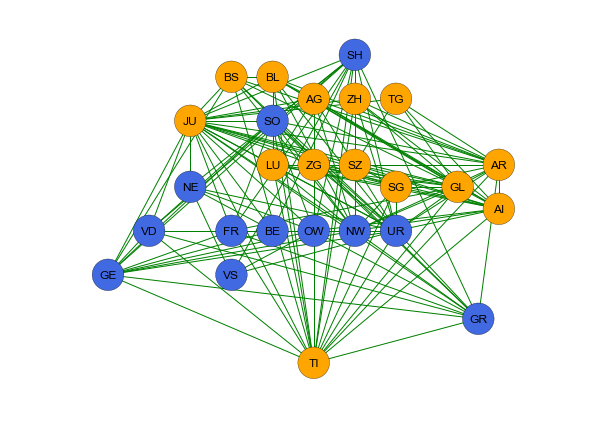

alpha: 0.1
Modularity score: 0.20668054110301765


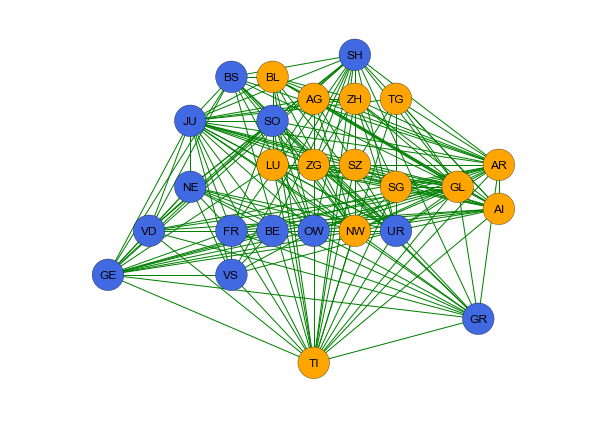

alpha: 0.025
Modularity score: 0.15666691418529244


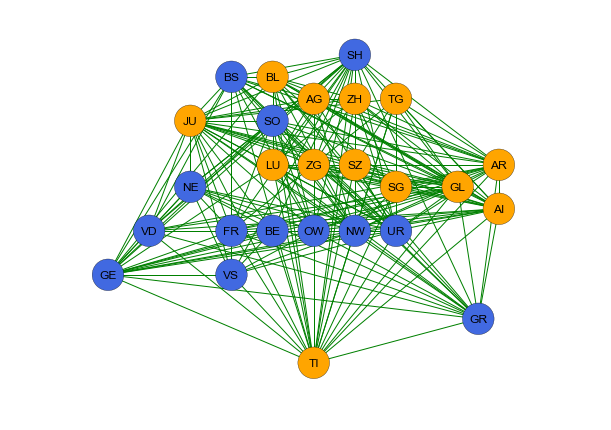

alpha: 0.01
Modularity score: 0.11710697183670155


In [73]:
import community
for k in range(len(alpha)):
    partition = community.best_partition(GRAPHS[k])

    for i in set(partition.values()):
        members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]

    values = [partition.get(node) for node in GRAPHS[k].nodes()]
    colors = {0 : 'orange', 1 : 'royalblue', 2 : 'violet', 3 : 'lightgreen'}
    cols = []
    for i in range(len(values)):
        cols.append(colors[values[i]])
    nx.draw(GRAPHS[k], pos,cmap = plt.get_cmap('brg'), node_color = cols, node_size=1000, with_labels=True,edge_color='green')
    plt.show()
    print('alpha:',alpha[k])
    print ("Modularity score:", community.modularity(partition, GRAPHS[k]))

We notice that the modularity score decreases with decreasing the threshold $alpha$, which means that the isolated graph components are less significantly connected in terms of modularity as we impose a more severe bound. This translates into  uncertainty for some nodes of the graph (for example Basel-Stadt, Nidwalden or Obwalden), which pass from one community to another. However, the two main components preserve their general structure, so that we can conclude our procedure is acceptably robust to little threshold variations.

# Male Marathon

Here we focus on the female runners competing in the Marathons (42 km) and compare their times splitting them into groups per Canton. We work on a subset of the mapped dataframe. The procedure is exactly the same as before.

In [74]:
df = geodata[(geodata.Sex=='M') &  (geodata.Distance>=41.0) & (geodata.Distance<=43.0)]
df.Time = df.Time.apply(lambda x: x.total_seconds()/60) # display time in minutes

C:\Users\Utente\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Cantonal differences:

In [75]:
from bokeh.charts import BoxPlot, output_file, show
from bokeh.plotting import figure, output_file, show

agg = df[['Time','LivingCanton']]
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = BoxPlot(agg, values='mean time [minutes]', label='Canton', outliers=False,legend=False,
            color='cornflowerblue',title='mean time boxplot for male marathon (42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

output_file("boxplot.html")

show(p)

In [76]:
import scipy.stats as stats
samples = []
for k in cantons:
    samples.append(df.Time[df.LivingCanton==k])

In [77]:
output_file("heteroschedasticity.html")

Nc = 1
sample = samples[Nc]
p = figure(title = 'Heteroschedasticity for time variable, Canton '+str(cantons[Nc]), plot_width=500, plot_height=500)
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'index'
p.yaxis[0].axis_label = 'residuals [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

# add a circle renderer with a size, color, and alpha
p.line(x=[0,len(sample)],y=[0,0],line_width=2,line_dash=[3,3],color='red')
p.circle(range(0,len(sample)), sample-np.mean(sample), size=5, color="navy", alpha=0.5)

# show the results
show(p)

Compute the p-value of the Shapiro-Wilk test for normality:

In [78]:
Nc = 1
sample = samples[Nc]
stats.shapiro(sample)

(0.9850495457649231, 2.834951247126567e-16)

In [79]:
# normality hypothesis: Gaussian distribution, Shapiro-Wilk test
from bokeh.models import Label

# add a circle renderer with a size, color, and alpha
from bokeh.charts import Histogram, output_file, show

df2 = pd.DataFrame({'time':sample})
p = Histogram(df2,values='time',color='navy',bins=30,
              title='Time PDF for Canton ' +str(cantons[Nc]),
              density=True,legend='top_right')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'time [minutes]'
p.yaxis[0].axis_label = 'density'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'
m = np.mean(sample)
sigma = np.std(sample)
def gaussian(y,m,sigma):
    return 1/math.sqrt(2*math.pi*sigma*sigma)*math.exp(-(y-m)*(y-m)/2/(sigma*sigma))
yy = np.arange(np.min(sample), np.max(sample), 0.1)
gg = []
for k in range(len(yy)):
    gg.append(gaussian(yy[k],m,sigma))
p.line(list(yy),gg,line_width=2,color='red',legend='Gaussian')

output_file("histogram_bins.html")

show(p)

Now we perform the crossed KS tests and report the p-values in a dataframe:

In [80]:
p_values = {}
for i in range(len(cantons)):
    for j in range(i,len(cantons)):
        p_values[(i,j)]=stats.ks_2samp(samples[i],samples[j])[1]

In [81]:
P_VALUES = pd.DataFrame()
for j in range(len(cantons)):
    col = []
    for i in range(0,j):
        p = p_values[(i,j)]
        col.append(p)
    col.append(1.0)
    for i in range(j+1,len(cantons)):
        p = p_values[(j,i)]
        col.append(p)
    col = pd.Series(data=col,index=cantons)
    P_VALUES[cantons[j]]=col

We report a subset of the dataframe for visualization purposes only:

In [82]:
P_VALUES[['VS','BE','VD','ZH']].loc[['VS','BE','VD','ZH']]

,VS,BE,VD,ZH
VS,1.000000e+00,6.382172e-04,1.323669e-08,1.811562e-28
BE,6.382172e-04,1.000000e+00,1.946849e-34,3.291551e-208
VD,1.323669e-08,1.946849e-34,1.000000e+00,8.398040e-16
ZH,1.811562e-28,3.291551e-208,8.398040e-16,1.000000e+00


Now we set a threshold alpha = 0.05 to mark all the significant p-values in the dataframe. This operation will allow us to observe which are the statistically significant differences among Cantons:

In [83]:
alpha = 0.05
for k in P_VALUES.columns:
    P_VALUES[k] = P_VALUES[k].apply(lambda y: (y<0.05))

In [84]:
P_VALUES[['VS','BE','VD','ZH','FR','TI']].loc[['VS','BE','VD','ZH','FR','TI']]

,VS,BE,VD,ZH,FR,TI
VS,False,True,True,True,True,True
BE,True,False,True,True,True,True
VD,True,True,False,True,True,True
ZH,True,True,True,False,True,True
FR,True,True,True,True,False,True
TI,True,True,True,True,True,False


In [85]:
positions = {}
positions['SH']=(0,0)
positions['ZH']=(0,-1)
positions['TG']=(1,-1)
positions['AG']=(-1,-1)
positions['BL']=(-2,-0.5)
positions['BS']=(-3,-0.5)
positions['SO']=(-2,-1.5)
positions['JU']=(-4,-1.5)
positions['SG']=(1,-3)
positions['AR']=(3.5,-2.5)
positions['AI']=(3.5,-3.5)
positions['GL']=(2.5,-3)
positions['SZ']=(0,-2.5)
positions['ZG']=(-1,-2.5)
positions['LU']=(-2,-2.5)
positions['NE']=(-4,-3)
positions['VD']=(-5,-4)
positions['GE']=(-6,-5)
positions['FR']=(-3,-4)
positions['BE']=(-2,-4)
positions['OW']=(-1,-4)
positions['NW']=(-0,-4)
positions['UR']=(1,-4)
positions['GR']=(3,-6)
positions['VS']=(-3,-5)
positions['TI']=(-1,-7)

In [86]:
import networkx as nx
G = nx.Graph()
cantons = list(cantons)
for i in range(len(cantons)):
    G.add_node(cantons[i],pos=positions[cantons[i]])
for i in range(len(cantons)):
    for j in range(i+1,len(cantons)):
        if P_VALUES[cantons[i]].loc[cantons[j]]==False:
            G.add_edge(cantons[i],cantons[j])

We apply again the Louvain algorithm to find hidden communities:

Community 0
['AR', 'SO', 'BS', 'FR', 'JU', 'VD', 'OW', 'VS', 'NE', 'BE', 'GE']
Community 1
['BL', 'TI', 'NW', 'AG', 'GR', 'LU', 'SH']
Community 2
['SZ', 'GL', 'SG', 'UR', 'AI', 'ZG', 'TG', 'ZH']


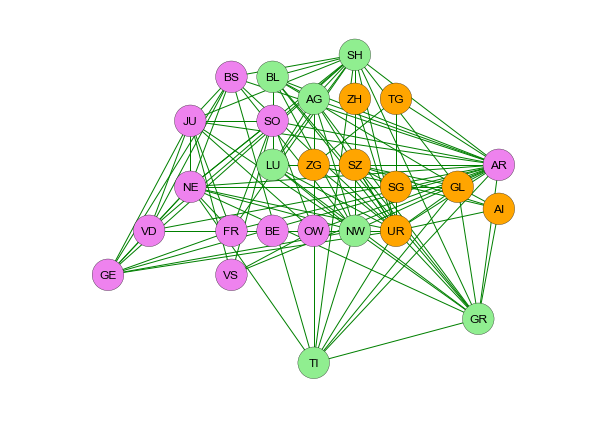

Modularity score: 0.24530763403753897


In [88]:
import community
partition = community.best_partition(G)

for i in set(partition.values()):
    print ("Community", i)
    members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]
    print (members)

colors = {0 : 'violet', 1: 'lightgreen', 2: 'orange', 3 : 'royalblue'}
cols = []
for i in range(len(values)):
    cols.append(colors[values[i]])
values = [partition.get(node) for node in G.nodes()]
nx.draw(G, pos,cmap = plt.get_cmap('brg'), node_color = cols, node_size=1000, with_labels=True,edge_color='green')
plt.show()

print ("Modularity score:", community.modularity(partition, G))

Also in this case the modularity of the graph is not particularly high, but in this case more components appear. Let visualize this difference in terms of the boxplots:

In [89]:
from bokeh.charts import BoxPlot, output_file, show
from bokeh.plotting import figure, output_file, show

agg = df[['Time','LivingCanton']]
community = agg.LivingCanton.apply(lambda x: partition[x])
agg['community']=community
agg = agg.rename(columns={'Time':'mean time [minutes]','LivingCanton':'Canton'})
p = BoxPlot(agg, values='mean time [minutes]', label='Canton', outliers=False,legend=False,
            color='community',title='mean time boxplot for male marathon (42 km)')
p.title.align = "center"
p.title.text_font_size = "18px"
p.xaxis[0].axis_label = 'Canton'
p.yaxis[0].axis_label = 'mean time [minutes]'
p.xaxis[0].axis_label_text_font_size = '16px'
p.yaxis[0].axis_label_text_font_size = '16px'

output_file("boxplot.html")

show(p)

C:\Users\Utente\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In this case the geographical partitioning of the graph seems much more fragile in terms of intuition; let us visualize it with another choropleth map to qualitatively validate it:

In [90]:
zone = []
for c in cantons:
    zone.append(partition[c])
geopartition = pd.DataFrame({'canton' : cantons, 'zone' : zone})
geopartition.head()

,canton,zone
0,VS,0
1,BE,0
2,FR,0
3,JU,0
4,AG,1


In [96]:
import folium
map_geopart = folium.Map(location=[46.8, 8],zoom_start=8)
state_geo = r'ch-cantons.topojson.json'
map_geopart.choropleth(geo_path=state_geo,key_on='feature.id',topojson='objects.cantons',data=geopartition,
                   columns=['canton','zone'],fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
                  legend_name='Geographical zone',
                  threshold_scale=[0,0.75,1.5,2.25,3])
map_geopart

In this case there are some components which are caught as equivalent by our approach, but which are not geograpically linked, at least at a first glance. However, there are two big regions which show a similar statistical distribution, one of which qualitatively corresponds to the female marathon case. By looking at the boxplots, one can verify that the male runners from this region are the "fastest", as it happens with women.

# Sensitivity analysis

As done with the female marathon, we perform a brief sensitivity analysis with respect to the threshold $alpha$.

In [92]:
# generate a list of dataframes, each one associated to a certain statistical threshold
alpha = [0.1,0.025,0.01]
P_VALUES = []
for k in range(len(alpha)):
    pv = pd.DataFrame()
    for j in range(len(cantons)):
        col = []
        for i in range(0,j):
            p = p_values[(i,j)]
            col.append(p)
        col.append(1.0)
        for i in range(j+1,len(cantons)):
            p = p_values[(j,i)]
            col.append(p)
        col = pd.Series(data=col,index=cantons)
        pv[cantons[j]]=col
    P_VALUES.append(pv)

In [93]:
for k in range(len(alpha)):
    for q in P_VALUES[k].columns:
        P_VALUES[k][q] = P_VALUES[k][q].apply(lambda y: (y<alpha[k]))

In [94]:
GRAPHS = []
for k in range(len(alpha)):
    G = nx.Graph()
    cantons = list(cantons)
    for i in range(len(cantons)):
        G.add_node(cantons[i],pos=positions[cantons[i]])
    for i in range(len(cantons)):
        for j in range(i+1,len(cantons)):
            if P_VALUES[k][cantons[i]].loc[cantons[j]]==False:
                G.add_edge(cantons[i],cantons[j])
    GRAPHS.append(G)

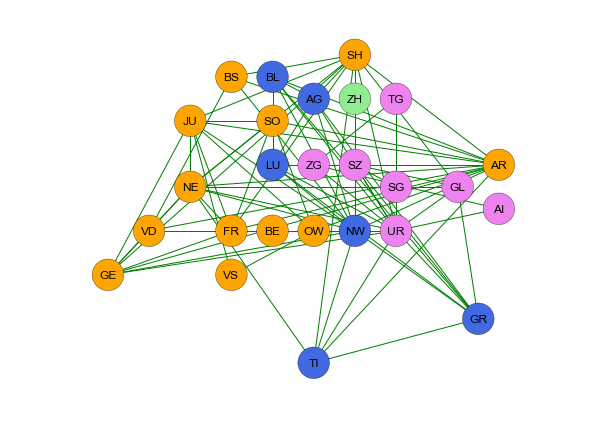

alpha: 0.1
Modularity score: 0.278203125


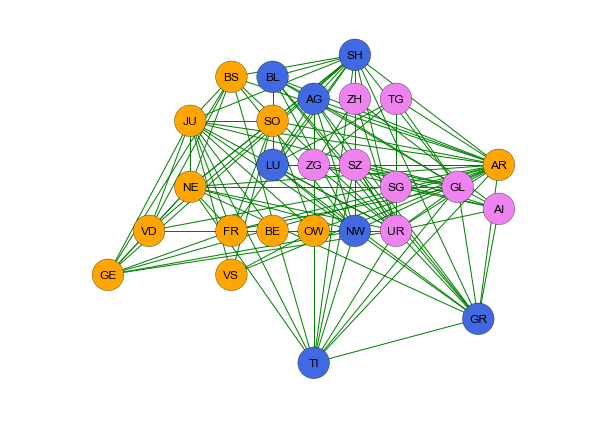

alpha: 0.025
Modularity score: 0.22652799999999995


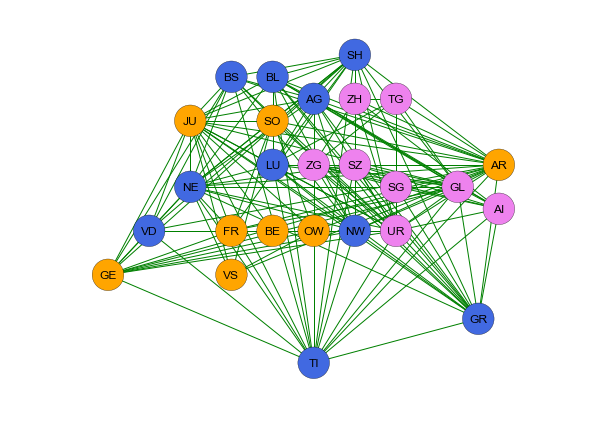

alpha: 0.01
Modularity score: 0.15796747316135235


In [95]:
import community
for k in range(len(alpha)):
    partition = community.best_partition(GRAPHS[k])

    for i in set(partition.values()):
        members = list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]

    values = [partition.get(node) for node in GRAPHS[k].nodes()]
    colors = {0 : 'orange', 1 : 'royalblue', 2 : 'violet', 3 : 'lightgreen'}
    cols = []
    for i in range(len(values)):
        cols.append(colors[values[i]])
    nx.draw(GRAPHS[k], pos,cmap = plt.get_cmap('brg'), node_color = cols, node_size=1000, with_labels=True,edge_color='green')
    plt.show()
    print('alpha:',alpha[k])
    print ("Modularity score:", community.modularity(partition, GRAPHS[k]))

We retrieve the same behaviour as for the women marathon with respect to $alpha$. Some nodes of the graph are more sensible to threshold variations (see Zurich, for instance), but the main structure of the partition is preserved.